In [68]:
import numpy.matlib
import numpy as np
import cmath
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from seaborn import heatmap

from matplotlib import cm

In [140]:
j=complex(0,1)           # iota , sqrt of -1

n_side=201               # no. of atoms along an edge of the array

n=n_side**2              # for a square atomi array

c_light=3*10**8          # m/s speed of light

lamda=500 * 10**-9       # (in m) wavelength of light

w=2*np.pi*c_light/lamda

a=0.2*lamda              # interatomic distance, in terms of lamda

L=(n_side-1)*a           # length of the atomic array

k=2*np.pi/lamda          # wavenumber of incidnet light

epsilon=8.85*10**-12     # SI units, permitivitty of free space

#assuming no non-radiative losses and w_a=w
w_a=w 
lamda_a=c_light/(w_a/(2*np.pi))

alpha=3/(4*np.pi**2)*epsilon*lamda_a**3*j # polarization of an atom

#Charactersitics of incident beam: 

#polaization direction
e_x = np.array([1,0.,0.]) # the vector for x polarized field

#waist
w_0 = 0.3*np.sqrt(n)*a

#Amplitude of the electric field of the beam
E_beam_amp=1 # defaulted to 1 in the function below

In [128]:
def Greens(m,l,k,r_1,r_2):
    '''Calculates the greens function G_{ml}(r_1,r_2) using eq S3'''
    if ((r_1[0]==r_2[0])and(r_1[1]==r_2[1])and(r_1[2]==r_2[2])):    #skip the same atom
        return 0
    else:
        r_vect=r_1-r_2 
        r=np.sqrt(np.sum(np.square(r_vect)))
        
        if m==l: # serves as kronecker delta
            t1=(1+ (j*k*r-1)/((k*r)**2))
        else:
            t1=0
        t2=(-1 + (3-3*k*r*j)/(k*r)**2)*r_vect[m]*r_vect[l]/r**2
        t3=(np.cos(k*r)+j*np.sin(k*r))*(t1+t2)/(4*np.pi*r)  #eq S3
        return t3

$$G_{ij}(k,\textbf{r}_1,\textbf{r}_2)=\frac{e^{ikr}}{4\pi r}\left[\left(1+\frac{ikr-1}{k^2r^2}\right)\delta_{ij}+\left(-1+\frac{3-3ikr}{k^2r^2}\right)\frac{r^ir^j}{r^2}\right]$$
where $\textbf{r}=\textbf{r}_1-\textbf{r}_2$, $r=\left|{\textbf{r}}\right|$ and $r^i=e_i.\textbf{r}$

In [72]:
def gaussian_beam(x,y,z,w_0,lamda,e_L,E_0_amp=1):
    '''returns the incident gaussian beam at the point (x,y,z)\
    given by equation eq. S55 \
    For z=0, exp(1/R(z)) term has been set to 0\
    lamda is the wavelength of the beam\
    w_0 is the beam waist at the focal point\
    e_L is the polarization vector\
    E_0_amp is the amplitude '''
    #wave number k
    k = 2*np.pi/lamda
    
    #below constants are as defined in the paper eq. S56
    z_R = np.pi*w_0**2/lamda 
    w_z = w_0*np.sqrt(1+(z/z_R)**2)

    phi_z = np.arctan(z/z_R)

    #Rz tends to infinity as z tends to 0. Which is why this ifelse condition is required \
    #to explicitly set the term involving  1/R to zero
    if z == 0:
        R_z = 1e100
        theta=k*z - phi_z #theta is the coeff of the exponential form of the complex number 
    else:
        R_z = z*(1+(z_R/z)**2)
        #This is the coeff of i in the exponential. 
        theta = k*z - phi_z + k*(x**2+y**2)/(2*R_z)
    
    #Following are the magnitude, real part and imaginary part respectively of the electric field of incident light
    E_0 = (E_0_amp*(w_0/w_z)*np.exp(-1*(x**2+y**2)/(w_z**2))*(np.cos(theta)+j*np.sin(theta)))*e_L # eq S55

    return E_0 #the final incident beam at (x,y,z) 

Gaussian beam equation:

$$\textbf{E}_0\left(x',y',z'\right) = E_0\textbf{e}_L\frac{w_0}{w(z')}e^{ikz'}e^{-i\phi(z')}e^{-\frac{x'^2+y'^2}{w^2(z')}}e^{ik\frac{x'^2+y'^2}{2R(z')}}$$
    
with the parameters being,
    
$$w(z)=w_0\sqrt{1+\left(\frac{z}{z_R}\right)^2},   z_R=\frac{\pi w_0^2}{\lambda},    R\left(z\right)=z\left[1+\left(\frac{z_R}{z}\right)^2\right],    \phi \left(z\right) = \arctan\left(\frac{z'}{z_R}\right)$$

Plot the variation of the electric field of the beam  with z axis at x=0,y=0

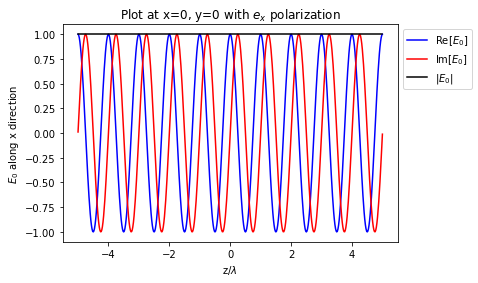

In [141]:
#position of x,y at which values of electric field along z axis are plotted
x = 0
y = 0


#initialization
#range of z
z = np.arange(-5, 5+10/500, 10/500)
E_incident_along_z=np.zeros(shape=(len(z),3),dtype=np.complex_)
for i in range(0,len(z)):
    E_incident_along_z[i]= gaussian_beam(x,y,z[i]*lamda,w_0,lamda,e_x,E_beam_amp)

plt.plot(z,E_incident_along_z[:,0].real,label='Re[$E_0$]',color='blue') #plotting only x component as remaining components are 0 because of polarization
plt.plot(z,E_incident_along_z[:,0].imag,label='Im[$E_0$]',color='red')
plt.plot(z,abs(E_incident_along_z[:,0]),label='|$E_0$|',color='black')
plt.xlabel('z/$\lambda$')
plt.ylabel('$E_0$ along x direction')
plt.legend(bbox_to_anchor=(1,1))
plt.title('Plot at x=0, y=0 with $e_x$ polarization')
# function to show the plot
plt.show()


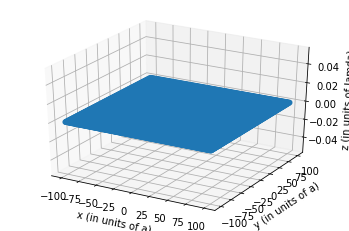

In [143]:
R=np.zeros(shape=(n,3)) 
for i in range(0,n):
    R[i]=((-L/2+a*(i%n_side)),(L/2-a*int((i/n_side))),0)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x (in units of a)')
ax.set_ylabel('y (in units of a) ')
ax.set_zlabel('z (in units of lamda) ')
#ax.view_init(3*10**-7,2*10**-7,'x')
ax.scatter3D(R[:,0]/a,R[:,1]/a,R[:,2]/lamda,cmap="Greens")

In [144]:
#Field value at points where atoms are placed i.e. z=0
E_0_at_atoms = np.zeros(shape=(n,3),dtype=np.complex_)

#position of atoms is at (x,y,0)

#The order is as explained in the final cell of gaussian_beam
for i in range(0,n):
      E_0_at_atoms[i] = gaussian_beam(R[i][0],R[i][1],R[i][2],w_0,lamda,e_x,E_beam_amp)
        
#E_0_at_atoms is a (n ,3) matrix, with n running over indices of atoms, 3 denoting the component of electric field at the atom 

1.0100000000000147e-05
-1.0000000000000003e-05


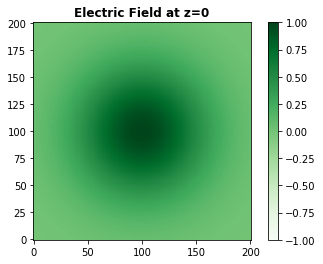

In [145]:
#Trying out different plots
x_axis=np.arange(-L/2,L/2+a,a)
y_axis=np.arange(L/2,-L/2+a,a)
print(x_axis.max())
print(x_axis.min())
z_min, z_max = -np.abs(E_0_at_atoms.real[:,0]).max(), np.abs(E_0_at_atoms.real[:,0]).max()

fig, ax = plt.subplots()

c = plt.imshow(E_0_at_atoms.real[:,0].reshape(n_side,n_side), cmap ='Greens', vmin = z_min, vmax = z_max,   interpolation ='nearest', origin ='lower')\
              # extent =[x_axis.min(), x_axis.max(), y_axis.min(), y_axis.max()],\
             
plt.colorbar(c)
 
plt.title('Electric Field at z=0' , fontweight ="bold")
plt.show()


Final 3N vector of electric field (magnitude, real part and imaginary part are separated). Here, the order goes as\

(-(n-1)*a/2,-(n-1)*a/2); (-(n+1)*a/2,-(n-1)*a/2); (-(n+3)*a/2,-(n-1)*a/2); ... ((n-1)*a/2,-(n-1)*a/2);  \
(-(n-1)*a/2,-(n+1)*a/2); ...                                                   ((n-1)*a/2,-(n+1)*a/2);\
.\
.\
.\
(-(n-1)*a/2,(n-1)*a/2); ...                                                    ((n-1)*a/2,(n-1)*a/2)\
\
where (x,y) represent coordinates of the atoms.



The block below performs the task of finding the field at the atoms using eq S $54$


$$\overline{E} = E_i(\textbf{r}_n) = \left[1-4\pi^2\frac{\alpha}{\epsilon_0\lambda^3}\lambda\overline{\overline{\mathbb{G}}}\right]^{-1}\overline{E}_0$$

 The block below calculates the field at any point, using equation S5
$$E_i(\textbf{r}) = E_{0,i}(\textbf{r}) + 4\pi^2\frac{\alpha}{\epsilon_o\lambda^3}\sum_j\sum_n\lambda
    G_{ij}(k,\textbf{r},\textbf{r}_n)E_j(\textbf{r}_n)$$

In [115]:
# Function which returns, incident, scattered and total electric field at position x, y, z
def E(x,y,z,E_at_atoms_V,w_0,R,lamda):   
    '''returns the incident electric field, scattered electric field and total electric field at the point (x,y,z)\
    E_at_atoms_V is the field at the atoms'''
    Greens_at_r = np.zeros(shape=(3,n,3),dtype=np.complex_)
    E_0_at_r = gaussian_beam(x,y,z,w_0,lamda,np.array([1,0,0]))# incident electric field
  
    for i in range(0,3):
        for m in range(0,3):
            for atoms_index in range(0,n):
                Greens_at_r[i,atoms_index,m]=Greens(i,m,k,(x,y,z),R[atoms_index])
                
    Greens_at_r_M = Greens_at_r.reshape(3,3*n)
    # the scattered electric field
    Scattered_field = (4*(np.pi**2)*alpha/(epsilon*lamda**2)) *np.matmul(Greens_at_r_M,E_at_atoms_V).reshape(3,)\
    #total electric field
    E_space = np.add(E_0_at_r , Scattered_field)
    
    return E_0_at_r, Scattered_field, E_space # incident field, scattered field, total field

This block find the field along the z-axis for a particulra x,y on the atomic plane

In [116]:
def a_graph(a_prime):
    R=np.zeros(shape=(n,3)) 
    L=(n_side-1)*a_prime
    for i in range(0,n):
        R[i]=((-L/2+a_prime*(i%n_side)),(L/2-a_prime*int((i/n_side))),0)
    
    #Field value at points where atoms are placed i.e. z=0
    E_0_at_atoms = np.zeros(shape=(n,3),dtype=np.complex_)

    #position of atoms is at (x,y,0)
    
    # changing the width of the beam 
    w_0_prime = 0.3*np.sqrt(n)*a_prime



    #The order is as explained in the final cell of gaussian_beam
    #for i in range(0,n):
         # E_0_at_atoms[i] = gaussian_beam(R[i][0],R[i][1],R[i][2],w_0_prime,lamda,e_x,E_beam_amp)
        
    #E_0_at_atoms is a (n ,3) matrix, with n running over indices of atoms, 3 denoting the component of electric field at the atom 

    G=np.zeros(shape=(n),dtype=np.complex_)

    #Calculating the G matrix to find the field at the atoms in n_1,3,n_2,3 form, where n_1 is index of r1, n_2 is index of r2
    # this g is used in eq S54
    #for r_1 in range(0,n):      
    
    index_of_center=int(n/2)
    for r_2 in range(0,n):
         G[r_2]=Greens(0,0,k,R[index_of_center],R[r_2])# using eq S3
         #using only G_xx, depend on polarization
                            
     # n must be odd for r_0 = 0
    delta,tau=0,0
    delta_next,tau_next=0,0
    r_iter=0
    print('entering loop')
    while(r_iter<=n_side/2):
        
       if (r_iter<=n_side/2): 
        for x in range(- r_iter,r_iter):
                iteration_index=index_of_center - r_iter*n_side + x
                delta_next=G[iteration_index ].real
                tau_next= G[iteration_index].imag
                if (abs(delta_next-delta)<delta/1000 and abs(tau_next - tau)<tau/1000):
                  delta =delta+delta_next
                  tau= tau + tau_next   
                  print('broken loop')
                  r_iter=n_side +1 
                  break# to exit loop
                delta =delta+delta_next
                tau= tau + tau_next   
       if (r_iter<=n_side/2): 
        for x in range(- r_iter,r_iter):
                iteration_index=index_of_center + r_iter*n_side + x
                delta_next=G[iteration_index ].real
                tau_next= G[iteration_index ].imag
                if (abs(delta_next-delta)<delta/1000 and abs(tau_next - tau)<tau/1000):
                  delta =delta+delta_next
                  tau= tau + tau_next   
                  print('broken loop')
                  r_iter=n_side +1
                  break # to exit loop
                delta =delta+delta_next
                tau= tau + tau_next   
       if (r_iter<=n_side/2):
        for y in range(- r_iter,r_iter):
                iteration_index=index_of_center - r_iter + y*n_side
                delta_next=G[iteration_index].real
                tau_next= G[iteration_index].imag
                if (abs(delta_next-delta)<delta/1000 and abs(tau_next - tau)<tau/1000):
                  delta =delta+delta_next
                  tau= tau + tau_next   
                  print('broken loop')
                  r_iter=n_side +1 
                  break # to exit loop
                delta =delta+delta_next
                tau= tau + tau_next                  
       if (r_iter<=n_side/2):
        for y in range(- r_iter,r_iter):
                iteration_index=index_of_center + r_iter + y*n_side
                delta_next=G[iteration_index].real
                tau_next= G[iteration_index].imag
                if (abs(delta_next-delta)<delta/1000 and abs(tau_next - tau)<tau/1000):
                  delta =delta+delta_next
                  tau= tau + tau_next   
                  print('broken loop')
                  r_iter=n_side +1
                  break # to exit loop
                delta =delta+delta_next
                tau= tau + tau_next           
       r_iter +=1
    delta_by_gamma=-3/2*lamda*delta
    tau_by_gamma=3*lamda*tau
    print('delta:',delta_by_gamma, 'tau: ', tau_by_gamma)
    # G is in 3n * 3n matrix  form  
   # G_M=G.reshape(3*n,3*n)

    # E_0_at_atoms is the incident electric field at atoms
   # E_0_V=E_0_at_atoms.reshape(3*n,1) # reshape E_n so that it can be multiplied by a 3n*3n  matrix

    # Calculating total electric fields at the atoms
    #I_M=np.identity(3*n,dtype=np.complex_)

    #INVERSE_M=np.linalg.inv(I_M-(4*(np.pi**2)*alpha/(epsilon*lamda**2)*G_M)) # the inverse term in eq S54
    
    #E_at_atoms_V=np.matmul(INVERSE_M,E_0_V) # eq S54 

    #E_at_atoms=E_at_atoms_V.reshape(n,3)
    
    # direction perpendicular to the central atom
   # i,s,Total_E= E(R[index_of_center,0],R[index_of_center,1],100*lamda,E_at_atoms_V,w_0_prime,R,lamda) 
    #Incident_E,s,t=E(R[index_of_center,0],R[index_of_center,1],-100*lamda,E_at_atoms_V,w_0_prime,R,lamda)
    #print(R[index_of_center])
    #print(Total_E[0],Incident_E[0])
    

    #T_observed=(abs(Total_E[0]/Incident_E[0]))**2
    return 0, delta_by_gamma, tau_by_gamma

In [146]:
a_list = np.arange(0.1*lamda, 2*lamda+2/100*lamda,1/100*lamda )
T_a = np.zeros(shape=(len(a_list),3)) # (observed,calulated)
for i in range(0,len(a_list),1):   
    x = a_graph(a_list[i])
    T_a[i]=x
    

entering loop
delta: -11.24640622645534 tau:  21.54606873757299
entering loop
delta: -8.030858669977881 tau:  17.963246417988074
entering loop
delta: -5.693608029362015 tau:  14.899816260213372
entering loop
delta: -4.2034636316702025 tau:  12.617971776353428
entering loop
delta: -3.0043698421901817 tau:  10.840442751014935
entering loop
delta: -2.206952259031683 tau:  9.268934808815699
entering loop
delta: -1.5773471141842244 tau:  8.141587540130752
entering loop
delta: -1.095772726443157 tau:  7.054813519283281
entering loop
delta: -0.7599159465089314 tau:  6.248199319115273
entering loop
delta: -0.45575002820877913 tau:  5.510574124878048
entering loop
delta: -0.26301832459258717 tau:  4.88127177732655
entering loop
delta: -0.07847174761761787 tau:  4.374594329459222
entering loop
delta: 0.04811999021951418 tau:  3.8771815093269604
entering loop
delta: 0.15073815707698465 tau:  3.5030290181869455
entering loop
delta: 0.24163774940637062 tau:  3.123892185727212
entering loop
delta: 0

In [100]:
print(len(T_a[:]))

40


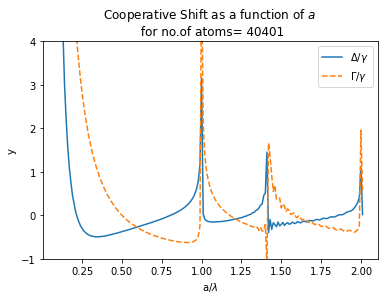

In [147]:
plt.plot(a_list[:]/lamda,-T_a[:,1],label='$\Delta/ \gamma$')#, s=10, c='black')
plt.plot(a_list[:]/lamda,T_a[:,2],label='$ \Gamma / \gamma$',linestyle='dashed')#, s=10, c='black')

plt.xlabel('a/$\lambda$')
plt.ylabel('y')
plt.ylim(-1,4)
plt.title(f'Cooperative Shift as a function of $a$ \n for no.of atoms= {n}')
plt.legend()
plt.show()
plt.show()